# Preprocessed Data

In [8]:
# retrieve the preprocessed data from previous notebook

%store -r x_train 
%store -r x_test 
%store -r y_train 
%store -r y_test 
%store -r Y
%store -r le

In [9]:
x_train.shape

(6985, 40, 174)

# Parallel CRNN

## Model Design

In [20]:
import numpy as np
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM, Reshape, concatenate
from keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.utils import np_utils
from sklearn import metrics 

num_rows = 40
num_columns = 174
num_channels = 1

x_train = x_train.reshape(x_train.shape[0], num_rows, num_columns, num_channels)
x_test = x_test.reshape(x_test.shape[0], num_rows, num_columns, num_channels)

num_labels = Y.shape[1]
filter_size = 2

# 1 layer
p1 = Sequential()
p1.add(Conv2D(filters=16, kernel_size=2, input_shape=(num_rows, num_columns, num_channels), activation='relu'))
p1.add(MaxPooling2D(pool_size=2))
p1.add(Dropout(0.2))
p1.add(Conv2D(filters=32, kernel_size=2, activation='relu'))
p1.add(MaxPooling2D(pool_size=2))
p1.add(Dropout(0.2))
p1.add(GlobalAveragePooling2D())

# 2 layer
p2 = Sequential()
p2.add(Conv2D(filters=16, kernel_size=2, input_shape=(num_rows, num_columns, num_channels), activation='relu'))
p2.add(MaxPooling2D(pool_size=2))
p2.add(Dropout(0.2))
p2.add(Conv2D(filters=64, kernel_size=2, activation='relu'))
p2.add(MaxPooling2D(pool_size=2))
p2.add(Dropout(0.2))
p2.add(GlobalAveragePooling2D())


#Layers concatenation
model_concat = concatenate([p1.output, p2.output], axis=-1) 
model_concat = Reshape((96,-1))(model_concat)
model_concat = LSTM(96)(model_concat)
model_concat = Dense(num_labels, activation='softmax')(model_concat)
model = Model(inputs=[p1.input, p2.input], outputs=model_concat)

## Model Compilation

In [21]:
# Compile the model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [22]:
# Display model architecture summary 
model.summary()

# Calculate pre-training accuracy 
score = model.evaluate([x_test, x_test], y_test, verbose=0)
accuracy = 100*score[1]

print("Pre-training accuracy: %.4f%%" % accuracy)

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
conv2d_25_input (InputLayer)    (None, 40, 174, 1)   0                                            
__________________________________________________________________________________________________
conv2d_27_input (InputLayer)    (None, 40, 174, 1)   0                                            
__________________________________________________________________________________________________
conv2d_25 (Conv2D)              (None, 39, 173, 16)  80          conv2d_25_input[0][0]            
__________________________________________________________________________________________________
conv2d_27 (Conv2D)              (None, 39, 173, 16)  80          conv2d_27_input[0][0]            
____________________________________________________________________________________________

## Model Training

In [24]:
from keras.callbacks import ModelCheckpoint 
from datetime import datetime 

num_epochs = 72
num_batch_size = 32

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.basic_pcrnn.hdf5', 
                               verbose=1, save_best_only=True)
start = datetime.now()

history = model.fit([x_train,x_train], y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=([x_test,x_test], y_test), callbacks=[checkpointer], verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Train on 6985 samples, validate on 1747 samples
Epoch 1/72
6985/6985 [==============================] - 148s 21ms/step - loss: 1.9208 - accuracy: 0.2677 - val_loss: 1.8573 - val_accuracy: 0.2914

Epoch 00001: val_loss improved from inf to 1.85729, saving model to saved_models/weights.best.basic_pcrnn.hdf5
Epoch 2/72
6985/6985 [==============================] - 142s 20ms/step - loss: 1.6644 - accuracy: 0.3702 - val_loss: 2.0276 - val_accuracy: 0.2782

Epoch 00002: val_loss did not improve from 1.85729
Epoch 3/72
6985/6985 [==============================] - 143s 20ms/step - loss: 1.5824 - accuracy: 0.4093 - val_loss: 1.7805 - val_accuracy: 0.3188

Epoch 00003: val_loss improved from 1.85729 to 1.78051, saving model to saved_models/weights.best.basic_pcrnn.hdf5
Epoch 4/72
6985/6985 [==============================] - 141s 20ms/step - loss: 1.5229 - accuracy: 0.4249 - val_loss: 1.7814 - val_accuracy: 0.3354

Epoch 00004: val_loss did not improve from 1.78051
Epoch 5/72
6985/6985 [==========

6985/6985 [==============================] - 140s 20ms/step - loss: 0.5794 - accuracy: 0.8000 - val_loss: 1.0553 - val_accuracy: 0.6405

Epoch 00038: val_loss did not improve from 0.96396
Epoch 39/72
6985/6985 [==============================] - 140s 20ms/step - loss: 0.5637 - accuracy: 0.8060 - val_loss: 1.1762 - val_accuracy: 0.6239

Epoch 00039: val_loss did not improve from 0.96396
Epoch 40/72
6985/6985 [==============================] - 143s 20ms/step - loss: 0.5477 - accuracy: 0.8122 - val_loss: 0.9751 - val_accuracy: 0.6800

Epoch 00040: val_loss did not improve from 0.96396
Epoch 41/72
6985/6985 [==============================] - 159s 23ms/step - loss: 0.5368 - accuracy: 0.8133 - val_loss: 1.1467 - val_accuracy: 0.6234

Epoch 00041: val_loss did not improve from 0.96396
Epoch 42/72
6985/6985 [==============================] - 143s 21ms/step - loss: 0.5101 - accuracy: 0.8278 - val_loss: 1.0510 - val_accuracy: 0.6600

Epoch 00042: val_loss did not improve from 0.96396
Epoch 43/72


## Testing the model

In [26]:
# Evaluating the model on the training and testing set
score = model.evaluate([x_train,x_train], y_train, verbose=0)
accuracy = 100*score[1]
print("Training Accuracy: %.4f%%" % accuracy)

score = model.evaluate([x_test,x_test], y_test, verbose=0)
accuracy = 100*score[1]
print("Testing Accuracy: %.4f%%" % accuracy)

Training Accuracy: 78.9692%
Testing Accuracy: 75.9588%


## Plotting the trained model

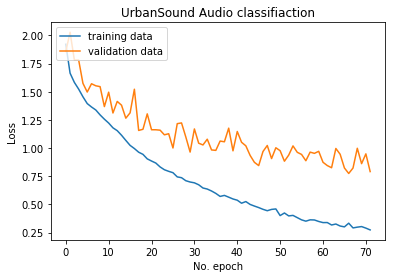

In [28]:
# Plot history: 
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='training data')
plt.plot(history.history['val_loss'], label='validation data')
plt.title('UrbanSound Audio classifiaction')
plt.ylabel('Loss')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()